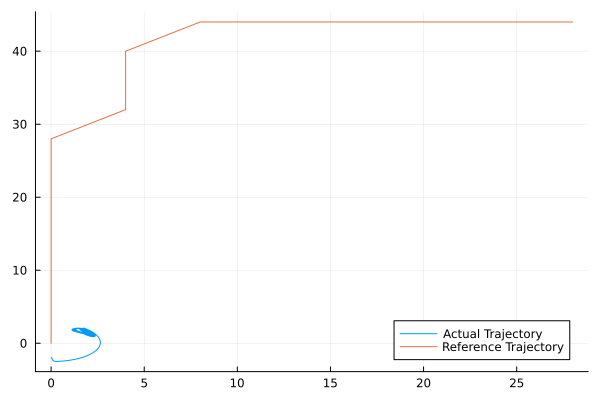

In [2]:
using DelimitedFiles, LinearAlgebra, Plots, StatsPlots, JuMP, Ipopt

function search_min_distance(x::Float64, y::Float64, x_ref::Vector{Float64}, y_ref::Vector{Float64})
    # find minimum distance between current car's position and reference and give the index of that point in the reference trajectory
    dis = zeros(length(x_ref))
    min_dis = 100000
    index = -1
    for i in 1:length(dis)-1
        dis[i] = (x - x_ref[i])^2 + (y - y_ref[i])^2
        if dis[i] < min_dis
            min_dis = dis[i]
            index = i
        end
    end
    return min_dis, index
end

function dynamics(x::Float64, y::Float64, v::Float64, theta::Float64, a::Float64, theta_dot::Float64)
    
#     x_next = 0.0
#     y_next = 0.0
#     v_next = 0.0
#     theta_next = 0.0
#     dt = 0.1 
    
#     x_next = x + v * cos(theta) * dt
#     y_next = y + v * sin(theta) * dt
#     v_next = v + a * dt
    
#     theta_next = theta + theta_dot * dt

#     return x_next, y_next, v_next, theta_next
    model = Model((Ipopt.Optimizer))
    set_silent(model)
    
    # Define variables
    @variable(model, x_next)
    @variable(model, y_next)
    @variable(model, v_next)
    @variable(model, theta_next)
    dt = 0.1 
    
    # Define constraints
    @NLconstraint(model, x_next == x + v * cos(theta) * dt)
    @NLconstraint(model, y_next == y + v * sin(theta) * dt)
    @NLconstraint(model, v_next == v + a * dt)
    @NLconstraint(model, theta_next == theta + theta_dot * dt)

    # Define objective function
    @NLobjective(model, Min, 0)
    
    # Solve problem
    optimize!(model)

    # Extract solution
    x_next = value(x_next)
    y_next = value(y_next)
    v_next = value(v_next)
    theta_next = value(theta_next)

    return x_next, y_next, v_next, theta_next
end



function direction(theta_ref::Float64, theta::Float64, theta_dot::Float64)
    model = Model((Ipopt.Optimizer))
    set_silent(model)
    @variable(model, theta_dot_raw)
    @constraint(model, theta_dot_raw == theta_dot)
    @NLconstraint(model, theta_dot_raw - theta_dot * (theta - theta_ref) <= 0)
    @NLconstraint(model, theta_dot_raw + theta_dot * (theta - theta_ref) >= 0)
    @objective(model, Min, 0)
    optimize!(model)
    return value(theta_dot_raw)
end

data = readdlm("left2.csv", ',', Float64)
x_ref = data[:,1]
y_ref = data[:,2]
theta_ref = zeros(length(x_ref))
for i in 1:length(x_ref)-1
    theta_ref[i] = pi + atan(y_ref[i+1]-y_ref[i], x_ref[i+1]-x_ref[i])
    
end

pid = Model(Ipopt.Optimizer)
t_start = time()
time_span = 30
dt = 0.1
Kp = 3
Kd = 1
v = 0.4
accel = 0.0
x_current = 0.0
y_current = -2.0
theta_current = -0.01
theta_dot_current = 0.0
min_dis_pre = 0.0
traj_x = [x_current]
traj_y = [y_current]
traj_theta = [theta_current]

for i in 1:1000
    
    min_dis, index = search_min_distance(x_current, y_current, x_ref, y_ref)
    
    theta_dot_raw = Kp * min_dis
    theta_dot_current = direction(theta_ref[index], theta_current, theta_dot_raw)
    push!(traj_theta, (theta_current - theta_ref[index]))
    theta_dot_current = theta_dot_current * Kd * abs(min_dis - min_dis_pre) # Using K_p & K_d together

    min_dis_pre = min_dis
    
    x_current, y_current, v, theta_current = dynamics(x_current, y_current, v, theta_current, accel, theta_dot_current)


    push!(traj_x, x_current)
    push!(traj_y, y_current)

end



plot(traj_x, traj_y, label = "Actual Trajectory")

plot!(x_ref, y_ref, label = "Reference Trajectory")

    
